In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
from future_features import tape
import numpy as np

In [2]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [3]:
from future_features import tape

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds

In [5]:
sess = tf.InteractiveSession()

In [6]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=500, n_components_in_mixture=2, n_features=2, n_sources=2, data_std_rate=1.)

In [7]:
generated = sess.run(ifa.tape)
fica = FastICA(n_components=2).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())
#initial = dict(generated)
#initial.pop('data')
#sess.run(ifa.assigner(**initial))
sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica))
#sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_std'], 10*np.ones(ifa.unconstrained_variables['mixture_component_std'].shape)))
#sess.run(tf.assign(ifa.unconstrained_variables['data_std'], 1e-3*np.ones(ifa.unconstrained_variables['data_std'].shape)))
start = sess.run(ifa.variables)
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
opt.minimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: nan
  Number of iterations: 71
  Number of functions evaluations: 143


In [8]:
predicted = sess.run(ifa.variables)
print(predicted)

{'mixture_component_std': array([[8.4176838e-02, 1.2516193e-04],
       [3.1124860e-02, 4.3152831e-05]], dtype=float32), 'mixture_weights': array([[0.00192733, 0.9980726 ],
       [0.01565975, 0.9843403 ]], dtype=float32), 'sources': array([[ 6.36948812e-07,  2.67242967e-07],
       [ 2.86701743e-06, -2.59595225e-07],
       [-6.42629914e-07, -6.46743885e-08],
       [-5.72364854e-07, -6.89622254e-07],
       [-7.89539683e-07, -8.21240121e-07],
       [-6.44129940e-08,  1.18219920e-01],
       [-5.36634786e-07,  6.08057917e-07],
       [ 9.56382155e-02,  8.73379975e-07],
       [-3.09610726e-07,  2.46581493e-07],
       [ 1.00072873e-06, -8.62759691e-07],
       [-2.50667453e-01,  2.24542646e-07],
       [-4.31738925e-07,  6.28405246e-07],
       [-4.44842470e-07,  1.15985479e-07],
       [-1.46173397e-06,  9.59438964e-08],
       [ 7.37899427e-07, -5.86206801e-02],
       [-4.90480652e-08, -6.22446872e-02],
       [ 4.12790740e-07, -7.97474172e-07],
       [-1.64209553e-06,  1.4867806

In [9]:
fgen = generated['factor_loadings']
fpred = predicted['factor_loadings']
fgen = 100*fgen/np.linalg.norm(fgen,axis=1,keepdims=True)
fpred = 100*fpred/np.linalg.norm(fpred,axis=1,keepdims=True)
fica_n = 100*fica/np.linalg.norm(fica, axis=1, keepdims=True)

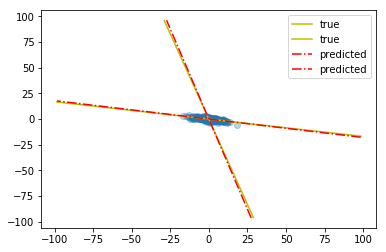

In [10]:
plt.scatter(*generated['data'].T,alpha=0.3)


for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()

#plt.plot((-1,1),(0,0),'k--')
#plt.plot((0,0),(-1,1),'k--')



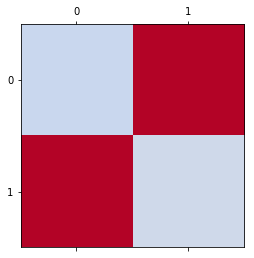

In [11]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],predicted['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)

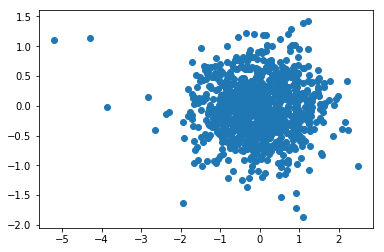

In [12]:
testinput = dict(ifa.variables)
testinput.pop('sources')

def centeredIndependentFactorAnalysisTest(n_observations, mc_samples, factor_loadings, mixture_weights, mixture_component_std, data_std):
    sources = ed.Independent(
        tfd.MixtureSameFamily(
            mixture_distribution=tfd.Categorical(probs=mixture_weights),
            components_distribution=tfd.Normal(loc=tf.zeros_like(mixture_component_std), scale=mixture_component_std, name='mixture_component')),
        reinterpreted_batch_ndims=1,sample_shape=(mc_samples, n_observations),name='sources')
    data_mean = tf.einsum('bik,kj->ijb', sources, factor_loadings, name='data_mean')
    data = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=tf.ones(mc_samples)/mc_samples),
                components_distribution=tfd.Normal(loc=data_mean, scale=data_std[:,:,None], name='data'), name='mc_approx')
    return data

plt.scatter(*sess.run(centeredIndependentFactorAnalysisTest(1000, 1, **testinput).sample()).T)